In [1]:
# pip install matplotlib

In [2]:
import os
import json
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt
from PIL import Image
import PIL.ImageDraw as ImageDraw
import imageio
import os
import wandb
import numpy as np
from time import time
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
# from DQN_analysis import DQN
env = gym.make('Pendulum-v1', g=9.81,render_mode="rgb_array")

In [3]:
lr = 0.0009
epsilon = 1.0
 # we want epsilon to be 0.01 after n episodes
gamma = 0.99
training_episodes = 200
epsilon_decay = (0.01 / epsilon) ** (1/150) 
target_update_interval = 5

In [4]:
class ReplayBuffer:
    def __init__(self, max_length, state_size, action_size, is_sarsa=False):
        self.is_sarsa = is_sarsa
        self.memory_counter = 0
        self.max_length = max_length
        self.state_memory = np.zeros((self.max_length, state_size))
        self.new_state_memory = np.zeros((self.max_length, state_size))
        self.action_memory = np.zeros((self.max_length, action_size), dtype=np.int8)
        if is_sarsa:
            self.new_action_memory = np.zeros((self.max_length, action_size), dtype=np.int8)
        self.reward_memory = np.zeros(self.max_length)
        self.done_memory = np.zeros(self.max_length, dtype=np.float32)

    def append(self, state, action, reward, new_state, done, new_action=None):
        idx = self.memory_counter % self.max_length

        self.state_memory[idx] = state
        self.action_memory[idx] = action  # Assuming action is a single float

        if self.is_sarsa:
            self.new_action_memory[idx] = new_action  # Assuming new_action is a single float

        self.new_state_memory[idx] = new_state
        self.reward_memory[idx] = reward
        self.done_memory[idx] = 1 - done
        self.memory_counter += 1

    def sample(self, batch_size):
        max_memory = min(self.memory_counter, self.max_length)
        sampled_batch = np.random.choice(max_memory, batch_size, replace=False)

        states= self.state_memory[sampled_batch]
        actions = self.action_memory[sampled_batch]
        rewards= self.reward_memory[sampled_batch]
        new_states = self.new_state_memory[sampled_batch]
        if self.is_sarsa:
            new_actions = self.new_action_memory[sampled_batch]
        dones = self.done_memory[sampled_batch]

        if not self.is_sarsa:
            return states, actions, rewards, new_states, dones
        else:
            return states, actions, rewards, new_states, new_actions, dones

In [5]:
class MyEpisodeSaver:
    def __init__(self, env, frames, algo, episode_number):
        self.env = env
        self.frames = frames
        self.dir = f'./gifs/{algo}/'
        self.episode_number = episode_number
        self.fname = f'episode_{self.episode_number}.gif'

        if not os.path.exists('./gifs'):
            os.mkdir('./gifs')

        if not os.path.exists(self.dir):
            os.mkdir(self.dir)

        self.labeled_frames = self.label_frames()

    def label_frames(self):
        labeled_frames = []

        for frame in self.frames:
            img = Image.fromarray(frame)
            draw = ImageDraw.Draw(img)
            # draw on each frame
            draw.text((10, 10), f'Episode: {self.episode_number}', fill=(255, 255, 255))
            labeled_frames.append(np.array(img))

        return labeled_frames

    def save(self):
        # labeled_frames = self.label_frames()
        # imageio.mimsave(self.dir + self.fname, labeled_frames, fps=60)
        imageio.mimsave(self.dir + self.fname, self.labeled_frames, fps=60)

In [6]:
import imageio, random
import pandas as pd
class DDQN:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay, epsilon_min=0.01, batch_size=128, fname='DDQN'):
        self.env = env
        self.action_size = 10
        self.state_size = env.observation_space.shape[0]
        self.action_space = [i for i in range(self.action_size)] 
        self.discrete_actions = np.linspace(-2.0, 2.0, num = self.action_size)

        self.alpha = lr  # learning rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = 0.01
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_interval = 100

        self.fname = fname
        self.memory = ReplayBuffer(10000, self.state_size, self.action_size)
        self.dqn_model = self.create_dqn('DQN-Model')
        self.update_counter = 0
        self.dqn_target_model = self.create_dqn('DQN-Target-Model')


    def create_dqn(self, name):
        model = Sequential([
            Dense(units=64, activation='leaky_relu', input_shape=(self.state_size,)),
            Dense(units=32, activation='leaky_relu'),
            Dense(units=self.action_size, activation='linear')
        ], name=name)

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
        return model

    def remember(self, state, action, reward, new_state, done):
        self.memory.append(state, action, reward, new_state, done)

    def act(self, state):
        state = np.reshape(state, [1, self.state_size])
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.dqn_model.predict(state, verbose=0)
            return np.argmax(q_values[0])

        # q_values = self.dqn_model.predict(state, verbose=0)[0]

        # # Sample action from a normal distribution centered around the action with the highest Q-value
        # chosen_action = np.random.normal(loc=self.action_space[np.argmax(q_values)], scale=self.epsilon)

        # # Clip the action to be within the action space
        # chosen_action = np.clip(chosen_action, self.action_space.min(), self.action_space.max())

        # return chosen_action

    def update(self):
        if self.memory.memory_counter > self.batch_size:
            state, action, reward, new_state, done = self.memory.sample(self.batch_size)

            q_current = self.dqn_target_model.predict(new_state, verbose=0) 
            q_future = self.dqn_model.predict(new_state, verbose=0)
            q_target = self.dqn_model.predict(state, verbose=0)

            best_actions = np.argmax(q_current, axis=1)

            for i in range(self.batch_size):
                q_target[i, action[i]] = reward[i] + self.gamma * q_future[i, best_actions[i]] * done[i]

            self.dqn_model.fit(x=state, y=q_target, verbose=0)
            self.update_counter += 1

            # soft update with tau
            main_weights = self.dqn_model.get_weights()
            target_weights = self.dqn_target_model.get_weights()

            for i in range(len(target_weights)):
                target_weights[i] = self.tau * main_weights[i] + (1 - self.tau) * target_weights[i]
            
            self.dqn_target_model.set_weights(target_weights)

            # # Soft target update with tau
            # if self.update_counter % self.target_update_interval == 0:
            #     main_weights = self.dqn_model.get_weights()
            #     target_weights = self.dqn_target_model.get_weights()

            #     new_weights = [(1 - self.tau) * target_w + self.tau * main_w for target_w, main_w in zip(target_weights, main_weights)]
            #     self.dqn_target_model.set_weights(new_weights)

    def train(self, n_episodes, max_steps=200, log_wandb=False,
              update=True, save_episodes=False, save_interval=10):
        history = {'reward': [], 'avg_reward_100': [], 'steps': []}

        for episode in range(n_episodes):
            # print(episode)
            start_time = time()
            state, info = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            episode_reward = 0
            episode_steps = 0
            episode_frames  = []
            # self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            for _ in range(max_steps):
                action = self.act(state)

                new_state, reward, done, _, _ = self.env.step([self.discrete_actions[action]]) # 5 values returned
                
                new_state = np.reshape(new_state, [1, self.state_size])
                episode_frames.append(self.env.render())

                if update:
                    self.remember(state, action, reward, new_state, done)
                    self.update()

                state = new_state
                episode_reward += reward
                episode_steps += 1

                if done:
                    break

            if log_wandb:
                wandb.log({
                    'reward': episode_reward,
                    'steps': episode_steps,
                    'epsilon': self.epsilon
                })

            if save_episodes:
                if (episode + 1) % save_interval == 0 or (episode == 0):
                    s = MyEpisodeSaver(self.env, episode_frames , self.fname, episode + 1)
                    s.save()

            print(f'[EP {episode + 1}/{n_episodes}] - Reward: {episode_reward:.4f} - Steps: {episode_steps} - Eps: {self.epsilon:.4f} - Time: {time() - start_time:.2f}s')
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            history['reward'].append(episode_reward)
            history['avg_reward_100'].append(np.mean(history['reward'][-100:]))
            history['steps'].append(episode_steps)
            df = pd.DataFrame(history)
            df.to_csv(f'./assets/{self.fname}.csv')

        self.env.close()

        if log_wandb:
            wandb.finish()

        self.save(f'{self.fname}.h5')

        return history

    def save(self, fname):
        if not os.path.exists('./assets'):
            os.mkdir('./assets')

        self.dqn_model.save(f'./assets/{fname}')

    def load(self, fname):
        self.dqn_model = load_model(f'./assets/{fname}')

In [7]:
# pip install gymnasium[classic-control]

In [8]:
model = DDQN(env=env, lr=lr, gamma=gamma, epsilon=epsilon, epsilon_decay=epsilon_decay)
model.train(training_episodes,save_episodes=True, save_interval=20)

[EP 1/200] - Reward: -1074.0881 - Steps: 200 - Eps: 1.0000 - Time: 21.54s
[EP 2/200] - Reward: -1280.3455 - Steps: 200 - Eps: 0.9698 - Time: 41.44s
[EP 3/200] - Reward: -887.1903 - Steps: 200 - Eps: 0.9404 - Time: 42.89s
[EP 4/200] - Reward: -1017.1525 - Steps: 200 - Eps: 0.9120 - Time: 42.14s
[EP 5/200] - Reward: -1038.6295 - Steps: 200 - Eps: 0.8844 - Time: 42.37s
[EP 6/200] - Reward: -992.2511 - Steps: 200 - Eps: 0.8577 - Time: 43.01s
[EP 7/200] - Reward: -1046.1330 - Steps: 200 - Eps: 0.8318 - Time: 42.36s
[EP 8/200] - Reward: -1047.5930 - Steps: 200 - Eps: 0.8066 - Time: 43.53s
[EP 9/200] - Reward: -1058.5295 - Steps: 200 - Eps: 0.7822 - Time: 43.30s
[EP 10/200] - Reward: -1093.6960 - Steps: 200 - Eps: 0.7586 - Time: 43.70s
[EP 11/200] - Reward: -1208.1933 - Steps: 200 - Eps: 0.7356 - Time: 43.61s
[EP 12/200] - Reward: -1051.4648 - Steps: 200 - Eps: 0.7134 - Time: 44.17s
[EP 13/200] - Reward: -879.0501 - Steps: 200 - Eps: 0.6918 - Time: 44.02s
[EP 14/200] - Reward: -926.1658 - Ste

{'reward': [-1074.088056506715,
  -1280.3454724811177,
  -887.1903081633734,
  -1017.1524985703237,
  -1038.6294590492614,
  -992.251143804224,
  -1046.133010281298,
  -1047.5930249464304,
  -1058.5295358606165,
  -1093.6959590895706,
  -1208.1932831128263,
  -1051.4648481210863,
  -879.0501428914215,
  -926.1657677276347,
  -1482.1789938931693,
  -998.2851068579498,
  -1281.3852615666656,
  -1060.3812408498334,
  -1164.4575499956425,
  -825.0104555359069,
  -1046.3619762257185,
  -977.8802582618439,
  -1231.751074975215,
  -903.6572839091159,
  -965.1556919527868,
  -1046.6077786597896,
  -1039.4324688135673,
  -508.59846927403674,
  -972.9815819110407,
  -799.2433419314389,
  -639.6573724745238,
  -607.902004549368,
  -920.9565054140264,
  -838.1241425045836,
  -755.1588453244074,
  -555.2028507720461,
  -819.2775883770405,
  -503.5700381387338,
  -646.5696575354967,
  -646.0700929522187,
  -908.4184014798316,
  -498.89909248011895,
  -641.8206675062987,
  -382.002549763459,
  -621.8

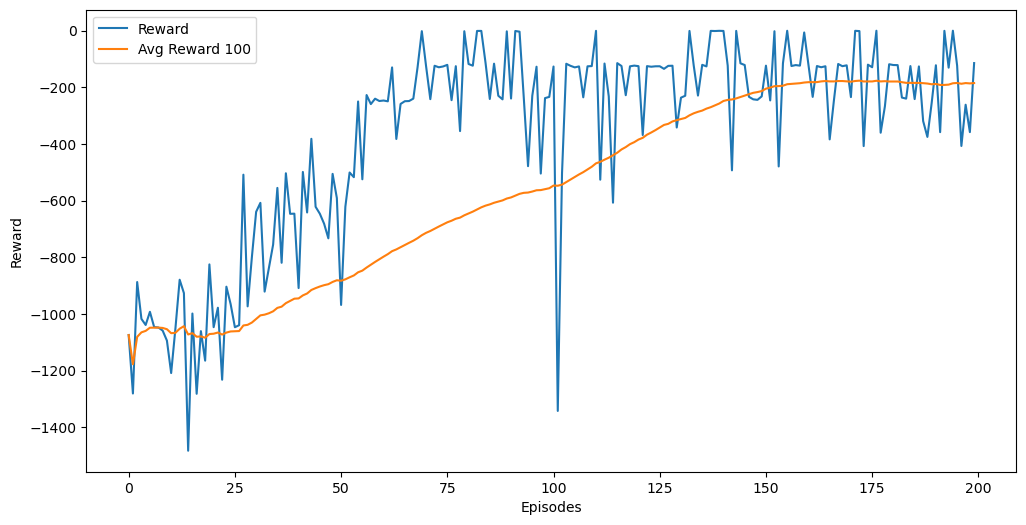

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(f'./assets/DDQN.csv')

plt.figure(figsize=(12, 6))
plt.plot(df['reward'], label='Reward')
plt.plot(df['avg_reward_100'], label='Avg Reward 100')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()
